<a href="https://colab.research.google.com/github/Shifalifatima/blog-posts/blob/main/FINAL_TSNE_RTSNE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

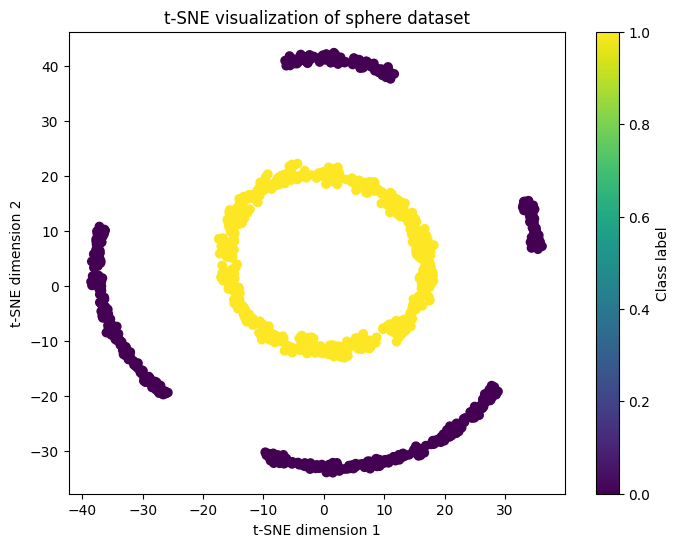

In [15]:
# prompt: generate tsne algorithm for sphere dataset from scratch and print tsne output image

import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate sphere dataset
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-SNE visualization of sphere dataset')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(label='Class label')
plt.show()


Iteration 0: KL Divergence = 3.3795
Iteration 100: KL Divergence = 1.2520
Iteration 200: KL Divergence = 1.1404
Iteration 300: KL Divergence = 1.0922
Iteration 400: KL Divergence = 1.0649
Iteration 500: KL Divergence = 1.0475
Iteration 600: KL Divergence = 1.0347
Iteration 700: KL Divergence = 1.0251
Iteration 800: KL Divergence = 1.0175
Iteration 900: KL Divergence = 1.0114
Iteration 999: KL Divergence = 1.0065


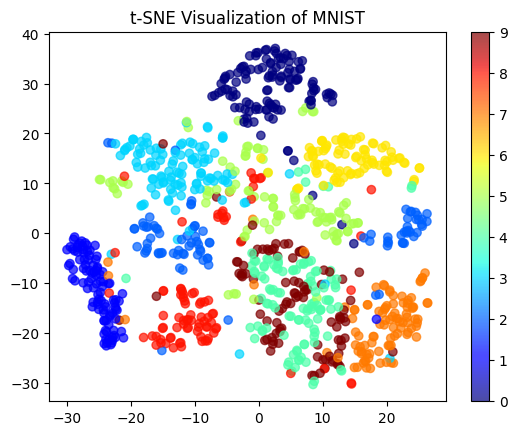

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X_total = pd.DataFrame(mnist["data"])
y_total = pd.DataFrame(mnist["target"])
X_reduced = X_total.sample(n=1000)
y_reduced = y_total.loc[X_reduced.index]
# PCA to keep 30 components
X = PCA(n_components=30).fit_transform(X_reduced)

def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain σ's based on user-specified perplexity.
    """
    result = np.inf
    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)
    for σ_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        p = np.exp(-(norm**2) / (2 * σ_search**2))
        p[i] = 0
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)
        H = -np.sum(p_new * np.log2(p_new))

        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search
    return σ

def get_original_pairwise_affinities(X: np.ndarray, perplexity: int = 10) -> np.ndarray:
    """
    Compute pairwise affinities in high-dimensional space.
    """
    n = len(X)
    p_ij = np.zeros(shape=(n, n))
    for i in range(n):
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * σ_i**2))
        np.fill_diagonal(p_ij, 0)
        p_ij[i, :] /= np.sum(p_ij[i, :])
    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)
    return p_ij

def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Convert conditional probabilities to symmetric joint probabilities.
    """
    n = len(p_ij)
    p_ij_symmetric = (p_ij + p_ij.T) / (2 * n)

    ε = np.nextafter(0, 1)
    return np.maximum(p_ij_symmetric, ε)

def initialization(X: np.ndarray, n_dimensions: int = 2, method: str = "random") -> np.ndarray:
    """
    Initialize solution in low-dimensional space.
    """
    if method == "random":
        return np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    elif method == "PCA":
        return PCA(n_components=n_dimensions).fit_transform(X)
    else:
        raise ValueError("Initialization method must be 'random' or 'PCA'.")

def compute_low_dim_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Compute affinities in low-dimensional space using t-distribution.
    """
    n = len(Y)
    q_ij = np.zeros(shape=(n, n))
    for i in range(n):
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1) ** 2
        q_ij[i, :] = (1 + norm) ** -1
        q_ij[i, i] = 0
    q_ij /= np.sum(q_ij)
    ε = np.nextafter(0, 1)
    return np.maximum(q_ij, ε)

def compute_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Compute the gradient of KL divergence.
    """
    n, dim = Y.shape
    gradient = np.zeros_like(Y)

    pq_diff = p_ij - q_ij
    for i in range(n):
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1) ** 2
        coeff = pq_diff[i, :] * (1 + norm) ** -1
        gradient[i, :] = np.sum((coeff[:, np.newaxis] * diff), axis=0)
    return 4 * gradient

def compute_kl_divergence(p_ij: np.ndarray, q_ij: np.ndarray) -> float:
    """
    Compute the Kullback-Leibler divergence between P and Q.
    """
    return np.sum(p_ij * np.log(p_ij / q_ij))

def tsne(X: np.ndarray, perplexity: int = 30, lr: float = 200, momentum: float = 0.8,
         iterations: int = 1000, initialization_method: str = "random") -> np.ndarray:
    """
    Run t-SNE to obtain low-dimensional representation.
    """
    n, dim = X.shape
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)
    Y = initialization(X, 2, initialization_method)
    Y_momentum = np.zeros_like(Y)

    for it in range(iterations):
        q_ij = compute_low_dim_affinities(Y)
        grad = compute_gradient(p_ij_symmetric, q_ij, Y)
        Y_momentum = momentum * Y_momentum - lr * grad
        Y += Y_momentum

        # Compute KL divergence every 100 iterations
        if it % 100 == 0 or it == iterations - 1:
            kl_divergence = compute_kl_divergence(p_ij_symmetric, q_ij)
            print(f"Iteration {it}: KL Divergence = {kl_divergence:.4f}")

    return Y

# Run t-SNE
Y_final = tsne(X)

# Plot results
plt.scatter(Y_final[:, 0], Y_final[:, 1], c=y_reduced.values.ravel(), cmap="jet", alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of MNIST")
plt.show()


# **TESTING ORGINAL TSNE WITH DIFFERENT DATA AND PERPLEXITY **

circles, perplexity=5 in 0.53 sec
circles, perplexity=30 in 0.84 sec
circles, perplexity=50 in 1 sec
circles, perplexity=100 in 1.4 sec
S-curve, perplexity=5 in 1.2 sec
S-curve, perplexity=30 in 1.3 sec
S-curve, perplexity=50 in 1.4 sec
S-curve, perplexity=100 in 1.3 sec
uniform grid, perplexity=5 in 1.2 sec
uniform grid, perplexity=30 in 1.1 sec
uniform grid, perplexity=50 in 1.3 sec
uniform grid, perplexity=100 in 1.4 sec


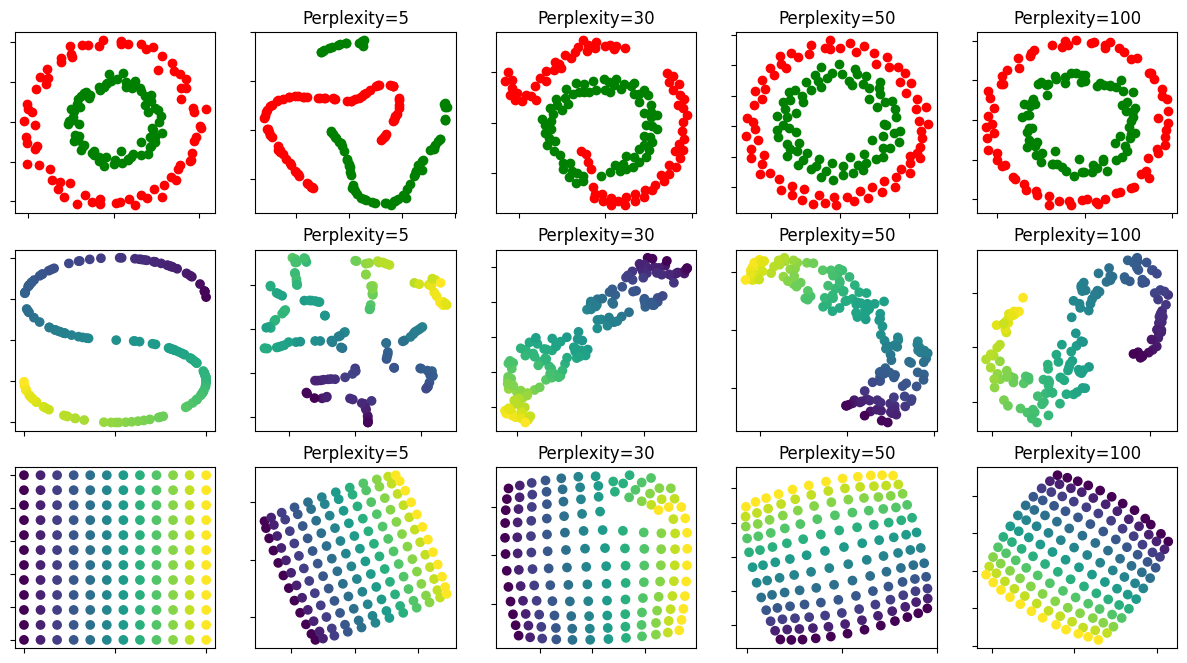

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter

from sklearn import datasets, manifold

n_samples = 150
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=0
)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        learning_rate="auto",
        max_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=400,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


plt.show()

TSNE ON SPHERE DATASET

Iteration 0: error is 20.537101
Iteration 100: error is 20.097937
Iteration 200: error is 3.569318
Iteration 300: error is 3.425551
Iteration 400: error is 3.179600
Iteration 500: error is 2.880388
Iteration 600: error is 2.598333
Iteration 700: error is 2.365287
Iteration 800: error is 2.181763
Iteration 900: error is 2.030761


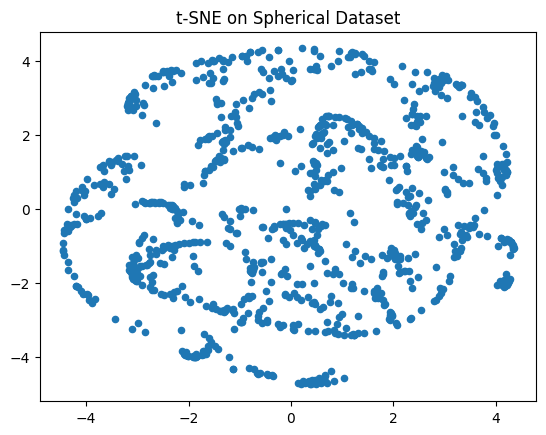

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Generate spherical dataset
def generate_sphere_dataset(n_samples, radius=1):
    np.random.seed(0)
    X = np.random.randn(n_samples, 3)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    X *= radius
    return X

# Compute pairwise affinities with Gaussian kernel
def compute_pairwise_affinities(X, perplexity):
    (n_samples, n_features) = X.shape
    distances = squareform(pdist(X, 'euclidean')) ** 2
    P = np.zeros((n_samples, n_samples))
    beta = np.ones((n_samples, 1))
    logU = np.log(perplexity)

    for i in range(n_samples):
        betamin = -np.inf
        betamax = np.inf
        Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))]
        (H, thisP) = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0

        while np.abs(Hdiff) > 1e-5 and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))] = thisP

    P = P + P.T
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)
    return P

# Compute the Gaussian kernel and entropy for a given precision
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

# Perform t-SNE
def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    (n_samples, n_features) = X.shape
    X = pca(X, initial_dims).real

    P = compute_pairwise_affinities(X, perplexity)
    P = P * 4
    P = np.maximum(P, 1e-12)

    Y = np.random.randn(n_samples, no_dims)
    dY = np.zeros((n_samples, no_dims))
    iY = np.zeros((n_samples, no_dims))
    gains = np.ones((n_samples, no_dims))

    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n_samples), range(n_samples)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q

        for i in range(n_samples):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < 0.01] = 0.01
        iY = 0.5 * iY - 0.2 * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n_samples, 1))

        if iter % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter, C))

        if iter == 100:
            P = P / 4

    return Y

# Perform PCA to reduce dimensionality
def pca(X, no_dims):
    (n_samples, n_features) = X.shape
    X = X - np.tile(np.mean(X, 0), (n_samples, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

# Main function
if __name__ == "__main__":
    n_samples = 1000
    X = generate_sphere_dataset(n_samples)

    Y = tsne(X, no_dims=2, initial_dims=3, perplexity=30.0, max_iter=1000)

    plt.scatter(Y[:, 0], Y[:, 1], 20)
    plt.title('t-SNE on Spherical Dataset')
    plt.show()

## **COMPLETE CODE FOR TSNE ON SPHERE WITH BINARY SEARCH , ENTROPY AND ALL **

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 3.4959852065567505
Iteration 50: Value of Cost Function is 1.9725605764139182
Iteration 100: Value of Cost Function is 1.9463124888266214
Iteration 150: Value of Cost Function is 1.9482917791858976
Iteration 200: Value of Cost Function is 1.9440343463233771
Iteration 250: Value of Cost Function is 1.9343871210695855
Iteration 300: Value of Cost Function is 0.9404598534288334
Iteration 350: Value of Cost Function is 0.8339264326107684
Iteration 400: Value of Cost Function is 0.7882976181138301
Iteration 450: Value of Cost Function is 0.7617005961565158
Iteration 500: Value of Cost Function is 0.7428255832473899
Iteration 550: Value of Cost Function is 0.7280120113971165
Iteration 600: Value of Cost Function is 0.7168759142305793
Iteration 650: Value of Cost Function

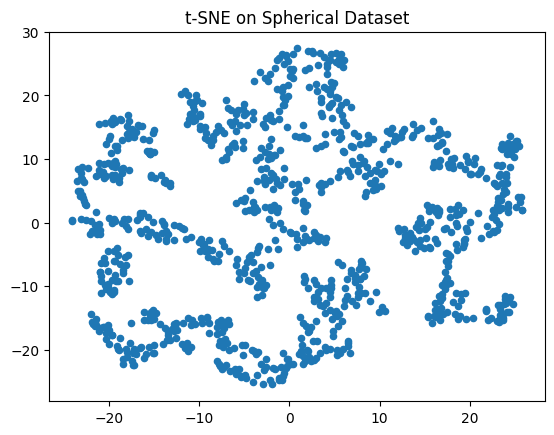

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


# Generate spherical dataset
def generate_sphere_dataset(n_samples, radius=1):
    np.random.seed(0)
    X = np.random.randn(n_samples, 3)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    X *= radius
    return X


def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain σ's based on user-specified perplexity.

    Parameters:
        diff_i (np.ndarray): Array containing the pairwise differences between data points.
        i (int): Index of the current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        float: The value of σ that satisfies the perplexity condition.
    """

    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for σ_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * σ_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search

    return σ


def get_original_pairwise_affinities(X: np.ndarray, perplexity: int = 10) -> np.ndarray:
    """
    Function to obtain affinities matrix.

    Parameters:
    X (np.ndarray): The input data array.
    perplexity (int): The perplexity value for the grid search.

    Returns:
    np.ndarray: The pairwise affinities matrix.
    """

    n = len(X)

    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n, n))
    for i in range(0, n):
        # Equation 1 numerator
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)  # Grid Search for σ_i
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * σ_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(p_ij, 0)

        # Equation 1
        p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)

    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij


def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Function to obtain symmetric affinities matrix utilized in t-SNE.

    Parameters:
    p_ij (np.ndarray): The input affinity matrix.

    Returns:
    np.ndarray: The symmetric affinities matrix.

    """
    print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij_symmetric = np.maximum(p_ij_symmetric, ε)

    print("Completed Symmetric p_ij Matrix. \n")

    return p_ij_symmetric


def initialization(
    X: np.ndarray, n_dimensions: int = 2, init: str = "random"
) -> np.ndarray:
    """
    Obtain initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        init (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        np.ndarray: The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # Sample Initial Solution
    if init == "random" or init != "PCA":
        y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    elif init == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        y0 = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return y0


def get_low_dimensional_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): The low-dimensional representation of the data points.

    Returns:
    np.ndarray: The low-dimensional affinities matrix.
    """

    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        # Equation 4 Numerator
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)

    return q_ij


def get_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    p_ij (np.ndarray): The joint probability distribution matrix.
    q_ij (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    np.ndarray: The gradient of the cost function at the current point Y.
    """

    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        # Equation 5
        diff = Y[i] - Y
        A = np.array([(p_ij[i, :] - q_ij[i, :])])
        B = np.array([(1 + np.linalg.norm(diff, axis=1) ** 2) ** (-1)])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient


def low_dimensional_embedding(
    p_ij: np.ndarray,
    Y0: np.ndarray,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
) -> list[np.ndarray, np.ndarray]:
    """
    Perform low-dimensional embedding using t-SNE algorithm.

    Args:
        p_ij (np.ndarray): The high-dimensional affinities matrix.
        Y0 (np.ndarray): The initial low-dimensional embedding.
        T (int, optional): The number of iterations. Defaults to 1000.
        η (int, optional): The learning rate. Defaults to 200.
        early_exaggeration (int, optional): The early exaggeration factor. Defaults to 4.
        n_dimensions (int, optional): The number of dimensions in the low-dimensional embedding. Defaults to 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embedding and the history of embeddings during optimization.
    """
    print("Optimizing Low Dimensional Embedding....")

    n = len(p_ij)

    # Initializations
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y[0] = np.zeros(shape=(n, n_dimensions))
    Y[1] = np.array(Y0)

    # Main For Loop for High to Low Dimensional Mapping
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = (
            Y[t] - η * gradient + α * (Y[t] - Y[t - 1])
        )  # Minimizing Cost Function

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij * np.log(p_ij / q_ij))
            print(f"Iteration {t}: error is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final error is {np.sum(p_ij * np.log(p_ij / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y


def tsne(
    X: np.ndarray,
    perplexity: int = 10,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
) -> list[np.ndarray, np.ndarray]:
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        X (np.ndarray): The input data matrix of shape (n_samples, n_features).
        perplexity (int, optional): The perplexity parameter. Default is 10.
        T (int, optional): The number of iterations for optimization. Default is 1000.
        η (int, optional): The learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): The factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dimensions (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embeddings and the history
            of embeddings at each iteration.

    """
    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - η * gradient + α * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y


if __name__ == "__main__":
    n_samples = 1000
    X = generate_sphere_dataset(n_samples)

    Y, _ = tsne(X, perplexity=30, T=1000, η=200, early_exaggeration=4, n_dimensions=2)

    plt.scatter(Y[:, 0], Y[:, 1], 20)
    plt.title('t-SNE on Spherical Dataset')
    plt.show()

CALCULATION OF PARAMETERS TO CHECK HHOW WELL IS EMBEDDIING I PERFORMING


Iteration 0: error is 20.533687547205016
Iteration 100: error is 20.05762262683947
Iteration 200: error is 3.5523569337634795
Iteration 300: error is 3.404182394363948
Iteration 400: error is 3.1695094102509263
Iteration 500: error is 2.8892603577893254
Iteration 600: error is 2.6154302101010107
Iteration 700: error is 2.381286404025386
Iteration 800: error is 2.1868689106778736
Iteration 900: error is 2.0250106525439446


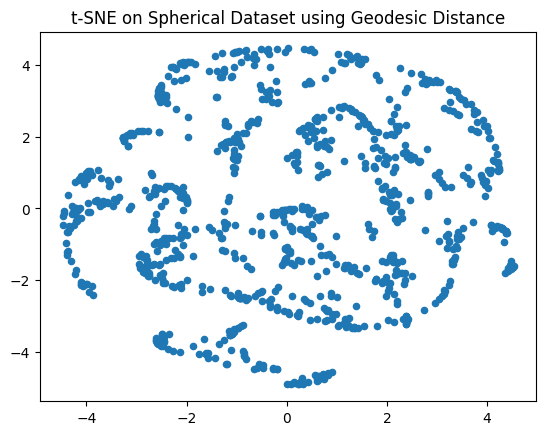

KL Divergence: -1379815.0698961075
Trustworthiness: 0.9901217741935484
Continuity: 0.9882014112903226
Silhouette Score: -0.007358553690553168
Neighborhood Preservation: 0.5902000000000003
Shepard Diagram Correlation: 0.23826332950657655


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

# Generate spherical dataset
def generate_sphere_dataset(n_samples, radius=1):
    np.random.seed(0)
    X = np.random.randn(n_samples, 3)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    X *= radius
    return X

# Compute geodesic distances
def compute_geodesic_distances(X, k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    graph = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(1, k):
            graph[i, indices[i, j]] = distances[i, j]
            graph[indices[i, j], i] = distances[i, j]
    geodesic_distances = shortest_path(graph, method='D', directed=False)
    return geodesic_distances

def compute_p_matrix(D, perplexity=30.0, tol=1e-5):
    (n, n) = D.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = (P + P.T) / np.sum(P + P.T)
    P = np.maximum(P, 1e-12)
    return P

def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    n, d = X.shape
    D = compute_geodesic_distances(X)
    P = compute_p_matrix(D, perplexity)
    P = P * 4
    P = np.maximum(P, 1e-12)

    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q

        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < 0.01] = 0.01
        iY = 0.5 * iY - 0.2 * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if iter % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter}: error is {C}")

        if iter == 100:
            P = P / 4

    return Y

def pca(X, no_dims):
    n, d = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    l, M = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

# Evaluation metrics
def kl_divergence(p, q):
    p = np.maximum(p, 1e-12)
    q = np.maximum(q, 1e-12)
    return np.sum(p * np.log(p / q))

def trustworthiness(X, X_embedded, n_neighbors=5):
    n_samples = X.shape[0]
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    ranks = np.argsort(np.argsort(pairwise_dists, axis=1), axis=1)
    ranks_embedded = np.argsort(np.argsort(pairwise_dists_embedded, axis=1), axis=1)
    trust = 0.0
    for i in range(n_samples):
        for j in range(n_samples):
            if ranks[i, j] < n_neighbors and ranks_embedded[i, j] >= n_neighbors:
                trust += (ranks_embedded[i, j] - n_neighbors + 1)
    return 1.0 - trust / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))

def continuity(X, X_embedded, n_neighbors=5):
    n_samples = X.shape[0]
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    ranks = np.argsort(np.argsort(pairwise_dists, axis=1), axis=1)
    ranks_embedded = np.argsort(np.argsort(pairwise_dists_embedded, axis=1), axis=1)
    cont = 0.0
    for i in range(n_samples):
        for j in range(n_samples):
            if ranks_embedded[i, j] < n_neighbors and ranks[i, j] >= n_neighbors:
                cont += (ranks[i, j] - n_neighbors + 1)
    return 1.0 - cont / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))

def silhouette(X_embedded):
    return silhouette_score(X_embedded, np.argmax(pairwise_distances(X_embedded), axis=1))

def neighborhood_preservation(X, X_embedded, n_neighbors=5):
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    neighbors = np.argsort(pairwise_dists, axis=1)[:, 1:n_neighbors+1]
    neighbors_embedded = np.argsort(pairwise_dists_embedded, axis=1)[:, 1:n_neighbors+1]
    preserved = 0.0
    for i in range(X.shape[0]):
        preserved += len(set(neighbors[i]).intersection(set(neighbors_embedded[i]))) / n_neighbors
    return preserved / X.shape[0]

def shepard_diagram(X, X_embedded):
    pairwise_dists = pairwise_distances(X).flatten()
    pairwise_dists_embedded = pairwise_distances(X_embedded).flatten()
    return spearmanr(pairwise_dists, pairwise_dists_embedded).correlation

# Main function
if __name__ == "__main__":
    n_samples = 1000
    X = generate_sphere_dataset(n_samples)

    Y = tsne(X, no_dims=2, initial_dims=3, perplexity=30.0, max_iter=1000)

    plt.scatter(Y[:, 0], Y[:, 1], 20)
    plt.title('t-SNE on Spherical Dataset using Geodesic Distance')
    plt.show()

    # Evaluate the embedding
    print("KL Divergence:", kl_divergence(pairwise_distances(X), pairwise_distances(Y)))
    print("Trustworthiness:", trustworthiness(X, Y))
    print("Continuity:", continuity(X, Y))
    print("Silhouette Score:", silhouette(Y))
    print("Neighborhood Preservation:", neighborhood_preservation(X, Y))
    print("Shepard Diagram Correlation:", shepard_diagram(X, Y))

### **MODIFIED TSNE WITH EUCLIDEANDISTANCE REPLACED WITH GEODESIC DISTANCE FOR SPEHERE WITH RETRACTION MAP APPLIED**

Iteration 100, cost: 2.754720738262109
Iteration 200, cost: 2.742149781595871
Iteration 300, cost: 2.7418418966801537
Iteration 400, cost: 2.7417789865244293
Iteration 500, cost: 2.741441612302688
Iteration 600, cost: 2.740981259030511
Iteration 700, cost: 2.740978017495802
Iteration 800, cost: 2.740978007101433
Iteration 900, cost: 2.740978007065194
Iteration 1000, cost: 2.740978007065058


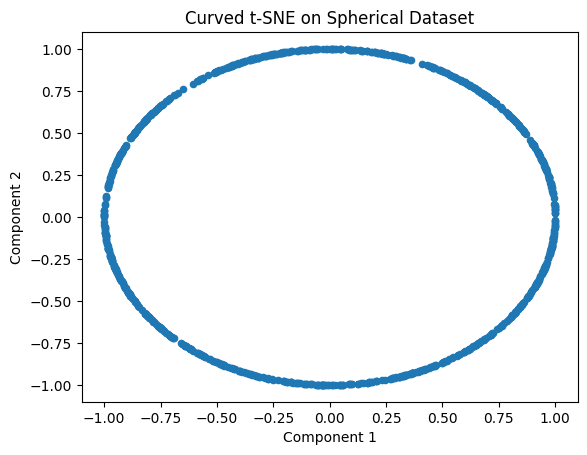

NameError: name 'P' is not defined

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")


# Generate spherical dataset
def generate_sphere_dataset(n_samples, radius=1):
    np.random.seed(0)
    X = np.random.randn(n_samples, 3)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    X *= radius
    return X


# Compute geodesic distances
def compute_geodesic_distances(X, k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    graph = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(1, k):
            graph[i, indices[i, j]] = distances[i, j]
            graph[indices[i, j], i] = distances[i, j]
    geodesic_distances = shortest_path(graph, method='D', directed=False)
    return geodesic_distances


# Compute pairwise probabilities Pij based on geodesic distances
def compute_pairwise_probabilities(D, perplexity=30.0, tol=1e-5):
    (n, n) = D.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = (P + P.T) / np.sum(P + P.T)
    P = np.maximum(P, 1e-12)
    return P


def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


# Compute low-dimensional pairwise probabilities Qij
def compute_low_dimensional_probabilities(Y):
    n = Y.shape[0]
    dist = distance_matrix(Y, Y) ** 2
    Q = (1 + dist) ** -1
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q)
    Q = np.maximum(Q, 1e-12)
    return Q


# Compute gradient of KL divergence
def compute_gradient(P, Q, Y):
    n = Y.shape[0]
    PQ_diff = P - Q
    dist = distance_matrix(Y, Y) ** 2
    grad = np.zeros_like(Y)

    for i in range(n):
        grad[i] = 4 * np.sum(((PQ_diff[:, i] * (1 + dist[:, i]) ** -1)[:, np.newaxis] * (Y[i] - Y)), axis=0)

    return grad


# Retract updated embedding back onto the manifold
def retraction(Y, v):
    Y_new = Y + v
    Y_new /= np.linalg.norm(Y_new, axis=1)[:, np.newaxis]
    return Y_new


# Perform t-SNE with curvature respect
def tsne_curved(X, perplexity=30, n_iter=1000, learning_rate=200.0, k=10, n_components=2):
    n = X.shape[0]
    D = compute_geodesic_distances(X, k)
    P = compute_pairwise_probabilities(D, perplexity)
    Y = np.random.randn(n, n_components)
    Y /= np.linalg.norm(Y, axis=1)[:, np.newaxis]

    for t in range(n_iter):
        Q = compute_low_dimensional_probabilities(Y)
        grad = compute_gradient(P, Q, Y)
        Y += -learning_rate * grad
        Y = retraction(Y, -learning_rate * grad)

        if (t + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {t+1}, cost: {C}")

    return Y


# Main function
if __name__ == "__main__":
    n_samples = 1000
    X = generate_sphere_dataset(n_samples)

    Y = tsne_curved(X, perplexity=30, n_iter=1000, learning_rate=200.0, k=10, n_components=2)

    plt.scatter(Y[:, 0], Y[:, 1], 20)
    plt.title('Curved t-SNE on Spherical Dataset')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

    # Evaluate the embedding
    print("KL Divergence:", np.sum(P * np.log(P / Q)))
    print("Trustworthiness:", trustworthiness(X, Y))
    print("Continuity:", continuity(X, Y))
    print("Silhouette Score:", silhouette(Y))
    print("Neighborhood Preservation:", neighborhood_preservation(X, Y))
    print("Shepard Diagram Correlation:", shepard_diagram(X, Y))

# **MODIIED TSNE AGAIN JUST ADDED PARAMETERS RO JUDGE RESULT**

Iteration 100, cost: 2.754720738262109
Iteration 200, cost: 2.742149781595871
Iteration 300, cost: 2.7418418966801537
Iteration 400, cost: 2.7417789865244293
Iteration 500, cost: 2.741441612302688
Iteration 600, cost: 2.740981259030511
Iteration 700, cost: 2.740978017495802
Iteration 800, cost: 2.740978007101433
Iteration 900, cost: 2.740978007065194
Iteration 1000, cost: 2.740978007065058


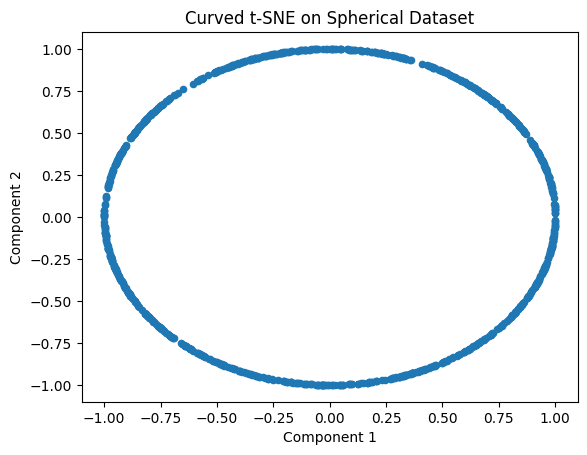

KL Divergence: 2.74097800706506
Trustworthiness: 0.9923016129032258
Continuity: 0.9316020161290323
Silhouette Score: 0.36237189682580073
Neighborhood Preservation: 0.14600000000000068
Shepard Diagram Correlation: 0.7447255703083444


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings("ignore")

# Generate spherical dataset
def generate_sphere_dataset(n_samples, radius=1):
    np.random.seed(0)
    X = np.random.randn(n_samples, 3)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    X *= radius
    return X

# Compute geodesic distances
def compute_geodesic_distances(X, k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    graph = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(1, k):
            graph[i, indices[i, j]] = distances[i, j]
            graph[indices[i, j], i] = distances[i, j]
    geodesic_distances = shortest_path(graph, method='D', directed=False)
    return geodesic_distances

# Compute pairwise probabilities Pij based on geodesic distances
def compute_pairwise_probabilities(D, perplexity=30.0, tol=1e-5):
    (n, n) = D.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = (P + P.T) / np.sum(P + P.T)
    P = np.maximum(P, 1e-12)
    return P

def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

# Compute low-dimensional pairwise probabilities Qij
def compute_low_dimensional_probabilities(Y):
    n = Y.shape[0]
    dist = distance_matrix(Y, Y) ** 2
    Q = (1 + dist) ** -1
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q)
    Q = np.maximum(Q, 1e-12)
    return Q

# Compute gradient of KL divergence
def compute_gradient(P, Q, Y):
    n = Y.shape[0]
    PQ_diff = P - Q
    dist = distance_matrix(Y, Y) ** 2
    grad = np.zeros_like(Y)

    for i in range(n):
        grad[i] = 4 * np.sum(((PQ_diff[:, i] * (1 + dist[:, i]) ** -1)[:, np.newaxis] * (Y[i] - Y)), axis=0)

    return grad

# Retract updated embedding back onto the manifold
def retraction(Y, v):
    Y_new = Y + v
    Y_new /= np.linalg.norm(Y_new, axis=1)[:, np.newaxis]
    return Y_new

# Perform t-SNE with curvature respect
def tsne_curved(X, perplexity=30, n_iter=1000, learning_rate=200.0, k=10, n_components=2):
    n = X.shape[0]
    D = compute_geodesic_distances(X, k)
    P = compute_pairwise_probabilities(D, perplexity)
    Y = np.random.randn(n, n_components)
    Y /= np.linalg.norm(Y, axis=1)[:, np.newaxis]

    for t in range(n_iter):
        Q = compute_low_dimensional_probabilities(Y)
        grad = compute_gradient(P, Q, Y)
        Y += -learning_rate * grad
        Y = retraction(Y, -learning_rate * grad)

        if (t + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {t+1}, cost: {C}")

    return Y

# Evaluation metrics
def kl_divergence(p, q):
    p = np.maximum(p, 1e-12)
    q = np.maximum(q, 1e-12)
    return np.sum(p * np.log(p / q))

def trustworthiness(X, X_embedded, n_neighbors=5):
    n_samples = X.shape[0]
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    ranks = np.argsort(np.argsort(pairwise_dists, axis=1), axis=1)
    ranks_embedded = np.argsort(np.argsort(pairwise_dists_embedded, axis=1), axis=1)
    trust = 0.0
    for i in range(n_samples):
        for j in range(n_samples):
            if ranks[i, j] < n_neighbors and ranks_embedded[i, j] >= n_neighbors:
                trust += (ranks_embedded[i, j] - n_neighbors + 1)
    return 1.0 - trust / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))

def continuity(X, X_embedded, n_neighbors=5):
    n_samples = X.shape[0]
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    ranks = np.argsort(np.argsort(pairwise_dists, axis=1), axis=1)
    ranks_embedded = np.argsort(np.argsort(pairwise_dists_embedded, axis=1), axis=1)
    cont = 0.0
    for i in range(n_samples):
        for j in range(n_samples):
            if ranks_embedded[i, j] < n_neighbors and ranks[i, j] >= n_neighbors:
                cont += (ranks[i, j] - n_neighbors + 1)
    return 1.0 - cont / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))

def silhouette(X_embedded):
    return silhouette_score(X_embedded, np.argmax(pairwise_distances(X_embedded), axis=1))

def neighborhood_preservation(X, X_embedded, n_neighbors=5):
    pairwise_dists = pairwise_distances(X)
    pairwise_dists_embedded = pairwise_distances(X_embedded)
    neighbors = np.argsort(pairwise_dists, axis=1)[:, 1:n_neighbors+1]
    neighbors_embedded = np.argsort(pairwise_dists_embedded, axis=1)[:, 1:n_neighbors+1]
    preserved = 0.0
    for i in range(X.shape[0]):
        preserved += len(set(neighbors[i]).intersection(set(neighbors_embedded[i]))) / n_neighbors
    return preserved / X.shape[0]

def shepard_diagram(X, X_embedded):
    pairwise_dists = pairwise_distances(X).flatten()
    pairwise_dists_embedded = pairwise_distances(X_embedded).flatten()
    return spearmanr(pairwise_dists, pairwise_dists_embedded).correlation

# Main function
if __name__ == "__main__":
    n_samples = 1000
    X = generate_sphere_dataset(n_samples)

    Y = tsne_curved(X, perplexity=30, n_iter=1000, learning_rate=200.0, k=10, n_components=2)

    plt.scatter(Y[:, 0], Y[:, 1], 20)
    plt.title('Curved t-SNE on Spherical Dataset')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

    # Evaluate the embedding
    D = compute_geodesic_distances(X, k=10)
    P = compute_pairwise_probabilities(D, perplexity=30)
    Q = compute_low_dimensional_probabilities(Y)
    print("KL Divergence:", np.sum(P * np.log(P / Q)))
    print("Trustworthiness:", trustworthiness(X, Y))
    print("Continuity:", continuity(X, Y))
    print("Silhouette Score:", silhouette(Y))
    print("Neighborhood Preservation:", neighborhood_preservation(X, Y))
    print("Shepard Diagram Correlation:", shepard_diagram(X, Y))